In [2]:
from data_processing1 import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
import climate_stats as cs
import scipy.stats as stats

from BucketModel import BucketModel, BucketModelOptimizer
from BucketModel.data_processing import (
    preprocess_for_bucket_model,
    run_multiple_simulations,
)
from BucketModel.bucket_model_plotter import *

from climate_simulation import run_model_for_future_climate, plot_climate_scenarios

from uncertainty_analysis import UncertaintyAnalysis, simulate_and_aggregate_streamflows

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#import statsmodels.tsa.api as smt
#import statsmodels.api as sm

from generate_future_climate import generate_future_climate

import os


import warnings
warnings.filterwarnings("ignore")

# (WEEK 1) Simulating ensembles with the WeaGETS weather generator.

### prep observations data

In [3]:
input_data_path = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/WeaGETS/Ex3-WeaGETS/Ex3-WeaGETS/HONDRICH_WEAGETS_IN.mat" #Your path to the OBSERVATIONS dataset
present_data = process_mat_file(input_data_path)
observed = ClimateExtreme(present_data)


## Testing different simulation methods:

In [4]:
# folder path für die location der matlab files
folder_path = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/"

filenames = ["1st_exp.mat", "1st_gamma.mat", "1st_skewed.mat", "1st_mixed.mat","2nd_exp.mat", "2nd_gamma.mat", "2nd_skewed.mat", "2nd_mixed.mat","3rd_exp.mat", "3rd_gamma.mat", "3rd_skewed.mat", "3rd_mixed.mat"]

filenames_skewed = ["1st_skewed.mat", "2nd_skewed.mat", "3rd_skewed.mat"]
filenames_gamma = ["1st_gamma.mat",  "2nd_gamma.mat", "3rd_gamma.mat"]
filenames_exp = ["1st_exp.mat", "2nd_exp.mat", "3rd_exp.mat"]
filenames_mixed = ["1st_mixed.mat", "2nd_mixed.mat", "3rd_mixed.mat"]
filenames_first = ["1st_exp.mat", "1st_gamma.mat", "1st_skewed.mat", "1st_mixed.mat"]
filenames_second =  ["2nd_exp.mat", "2nd_gamma.mat", "2nd_skewed.mat", "2nd_mixed.mat"]

filenames_chosen = ["1st_exp.mat", "2nd_mixed.mat" ]

### Comparison of extreme values

In [5]:
def plot_extreme_comparison_multi(
    filename,
    simulated_extremes,
    observed_extremes,
    column: str,
    units: str,
    quantile: float = 0.95,

) -> None:
    threshold_self = simulated_extremes.data[column].quantile(quantile)
    extremes_self = simulated_extremes.data[simulated_extremes.data[column] > threshold_self][column].values
    sns.kdeplot(extremes_self, label= filename , shade=True)
    

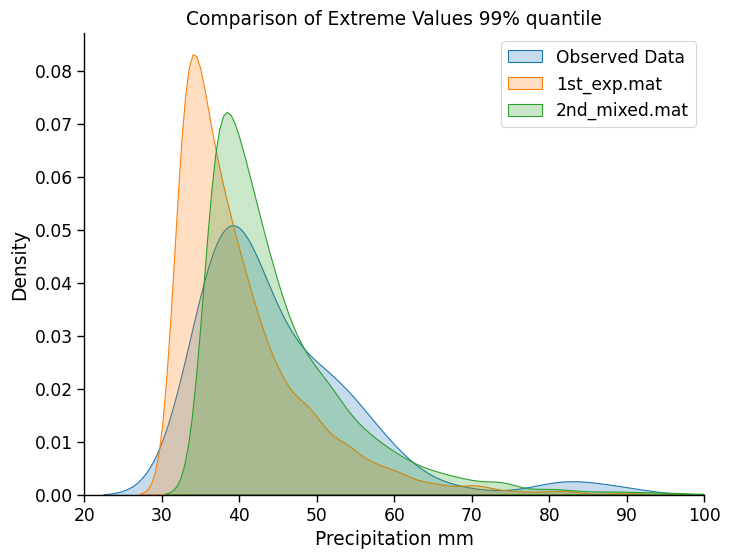

In [6]:
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=(8, 6))
column="Precipitation"
quantile=0.99
threshold_other = observed.data[column].quantile(quantile)
extremes_other = observed.data[observed.data[column] > threshold_other][column].values
sns.kdeplot(extremes_other, label="Observed Data", shade=True)

for filename in filenames_chosen: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    file_data_extremes = ClimateExtreme(file_data)
    plot_extreme_comparison_multi(filename, file_data_extremes,observed,  column="Precipitation", quantile=0.99,  units="mm")

plt.title("Comparison of Extreme Values 99% quantile")
plt.xlabel("Precipitation mm")
plt.ylabel("Density")
plt.xlim(20,100)
sns.despine()
plt.legend()
plt.show()

### Number of wet days

In [7]:
def plot_wet_days_multi(
    observations: pd.DataFrame, simulation: pd.DataFrame, filename
) -> None:
    """Plot the number of wet days from observations and simulation.

    Args:
        observations (pd.DataFrame): The observed data.
        simulation (pd.DataFrame): The simulated data.
        output_destination (str): File path to save the figure. If None, the plot will be displayed instead of saving.
    """
    sim_wet_days = cs.add_is_wet_column(simulation)
    sim_grouped = cs.group_data(sim_wet_days, ["Simulation", "Year", "Month"])
    sim_median = sim_grouped.groupby("Month")["is_wet"].median()


    sns.lineplot(
        data=sim_median, marker="o", label=filename
    )





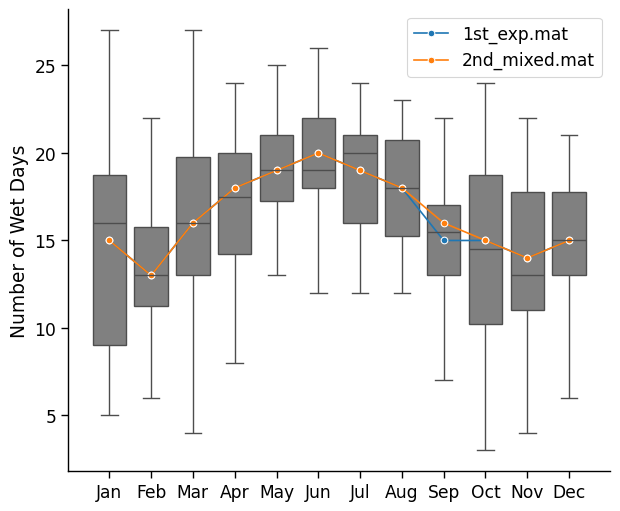

In [9]:
observations=present_data

obs_wet_days = cs.add_is_wet_column(observations)
obs_grouped = cs.group_data(obs_wet_days, ["Year", "Month"])
obs_median = obs_grouped.groupby("Month")["is_wet"].median()

plt.figure(figsize=(7,6))
sns.boxplot(data=obs_grouped, x="Month", y="is_wet", color='gray', showfliers=False)
for filename in filenames_chosen: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    plot_wet_days_multi(observations, file_data, filename)

sns.despine()
plt.legend()
plt.ylabel("Number of Wet Days")
plt.xlabel("")
plt.show()

### mean and std temperature

In [ ]:
def plot_mean_and_std_multi(filename, simulation: pd.DataFrame) -> None:
    simul_stats_monthly = cs.calculate_monthly_stats(simulation, include_simulation=True)
    simul_stats_monthly = simul_stats_monthly.groupby("Month_").mean().reset_index()

    sns.lineplot(
        x=simul_stats_monthly["Month_"],
        y=simul_stats_monthly["T_avg_mean"],
        label="Mean " + filename,
        linestyle="-",
    )
    sns.lineplot(
        x=simul_stats_monthly["Month_"],
        y=simul_stats_monthly["T_avg_std"],
        label="Std " + filename,
        linestyle="--",
    )

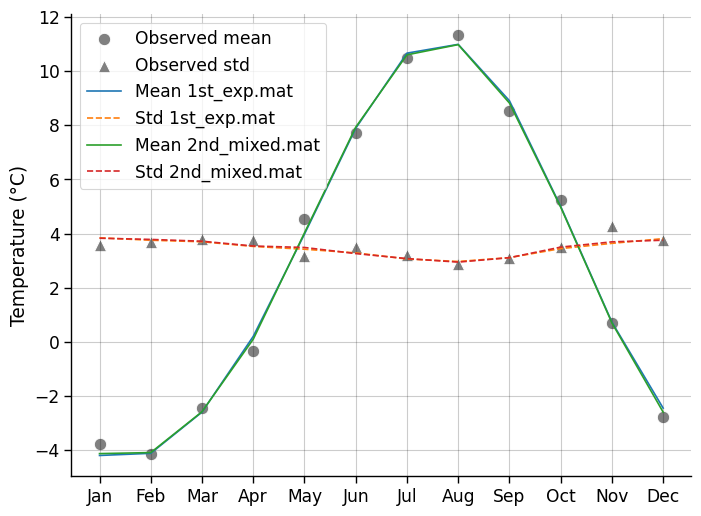

In [ ]:
obs_stats_monthly = cs.calculate_monthly_stats(observations)
obs_stats_monthly = obs_stats_monthly.groupby("Month_").mean().reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=obs_stats_monthly["Month_"],
    y=obs_stats_monthly["T_avg_mean"],
    label="Observed mean",
    color='gray',
    marker="o",
    s=80,
)
sns.scatterplot(
    x=obs_stats_monthly["Month_"],
    y=obs_stats_monthly["T_avg_std"],
    label="Observed std",
    color='gray',
    marker="^",
    s=80,
)

for filename in filenames_chosen: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    plot_mean_and_std_multi(filename, file_data)

plt.legend()
plt.ylabel("Temperature (°C)")
plt.xlabel("")
plt.grid(linestyle="-", alpha=0.2, color="black")
sns.despine()

plt.show()

### ECDF

In [ ]:
def plot_ECDF_multi(filename, simulation: pd.DataFrame) -> None:
    sns.ecdfplot(simulation["Precipitation"], label=filename)


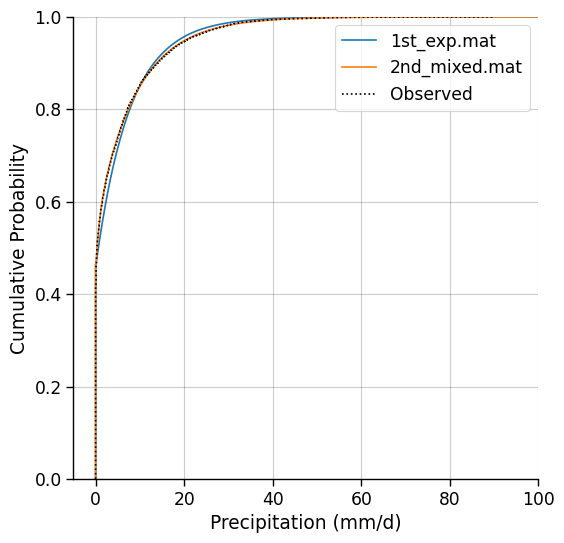

In [ ]:
plt.figure(figsize=(6,6))

for filename in filenames_chosen:
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    plot_ECDF_multi(filename, file_data)
sns.ecdfplot(observations["Precipitation"], label="Observed", color='black', linestyle=':')
plt.legend()
plt.ylabel("Cumulative Probability")
plt.xlabel("Precipitation (mm/d)")
plt.xlim(-5,100)
plt.grid(linestyle="-", alpha=0.2, color="black")
sns.despine()
plt.show()

### ks test

C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/1st_exp.mat
KS Tests Completed.


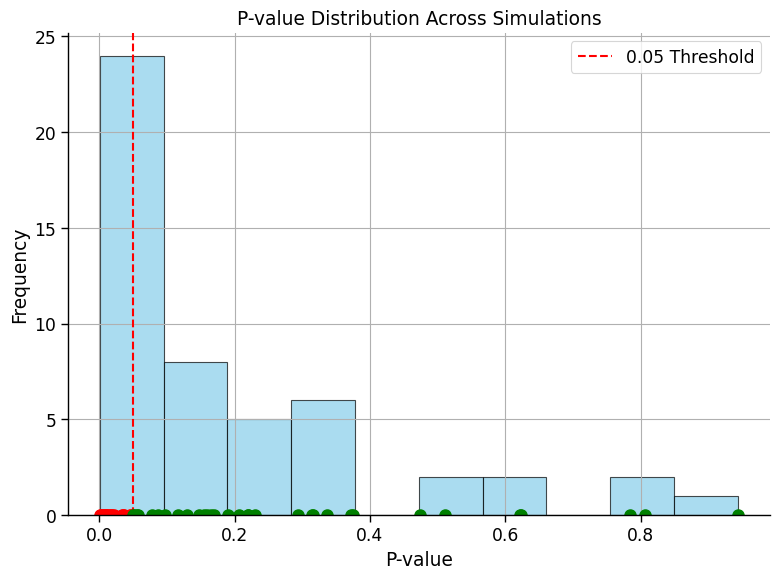

C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/2nd_mixed.mat
KS Tests Completed.


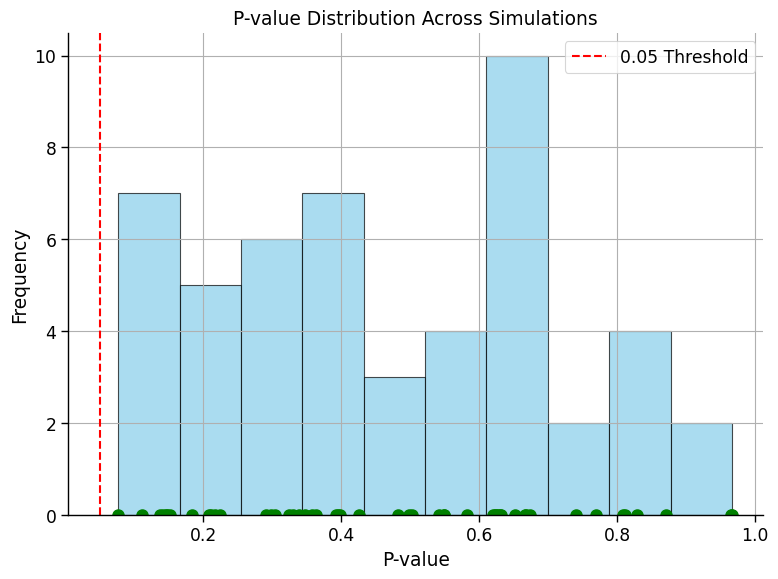

In [ ]:
for filename in filenames_chosen:
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    print(file_path)
    file_data_extremes = ClimateExtreme(file_data)
    ks_results = file_data_extremes.run_simulation_ks_tests(observed_data=observed, column="Precipitation", quantile=0.95)
    file_data_extremes.plot_ks_results(ks_results)

## Best simulation Method:
2nd order markov's chain using mixed exponential distribution

In [ ]:
best_file_path = folder_path + "2nd_mixed.mat"
latterbach_out = process_mat_file(best_file_path)

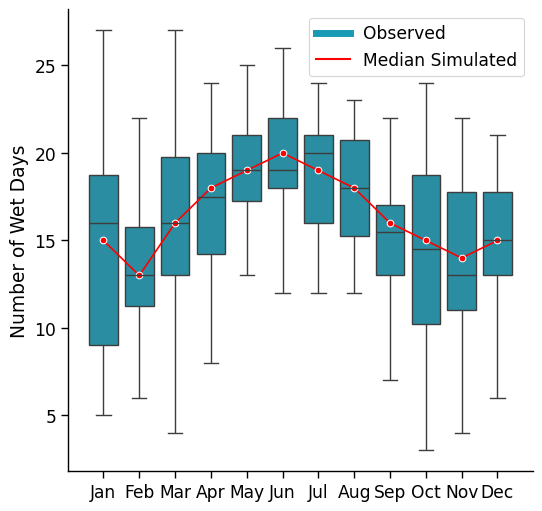

In [ ]:
cs.plot_wet_days(
    present_data,
    latterbach_out
) # You can add the output_destination parameter to save the plot

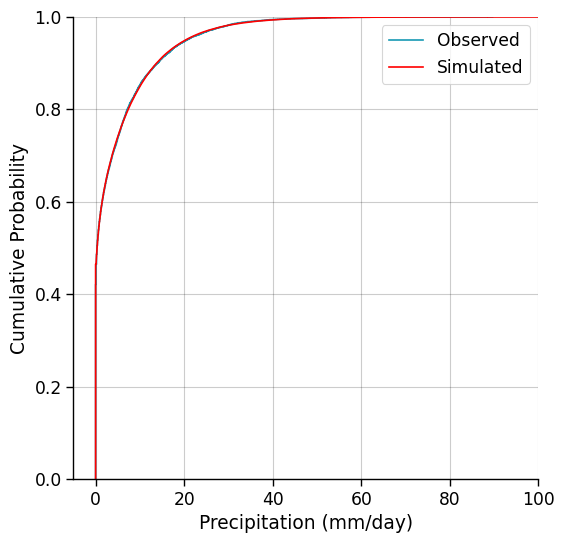

In [ ]:
cs.plot_ECDF(
    observations=present_data,
    simulation=latterbach_out,
    column="Precipitation",
    xlabel="Precipitation (mm/day)",
)

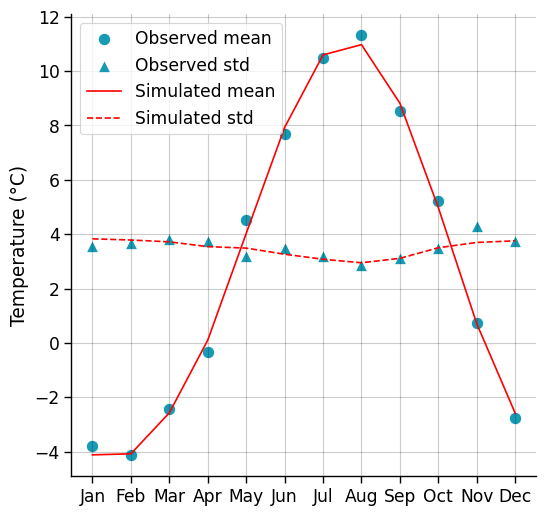

In [ ]:
cs.plot_mean_and_std(observations=present_data, simulation=latterbach_out)

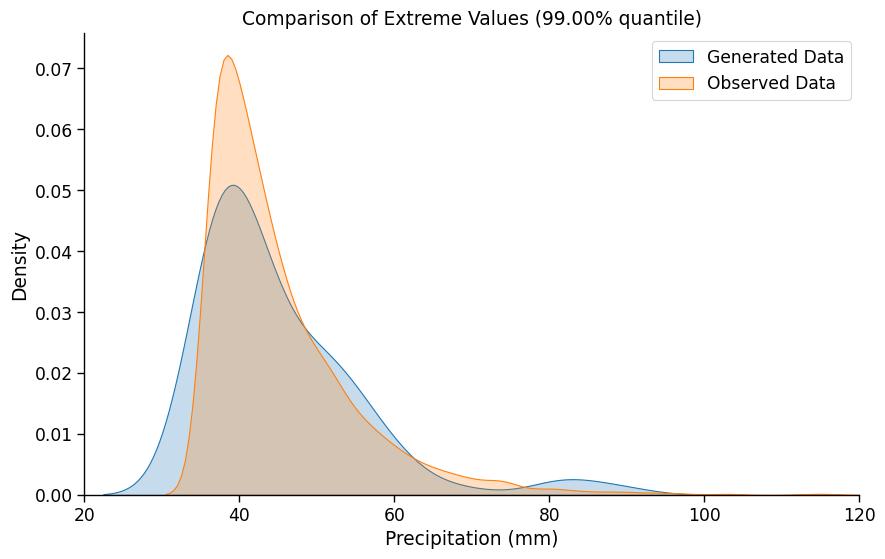

In [ ]:
# Create instances of ClimateExtreme Class
latterbach = ClimateExtreme(latterbach_out)

#These plots contain the data points 
observed.plot_extreme_comparison(column="Precipitation", other=latterbach, quantile=0.99, output_destination="", units="mm")

KS Tests Completed.


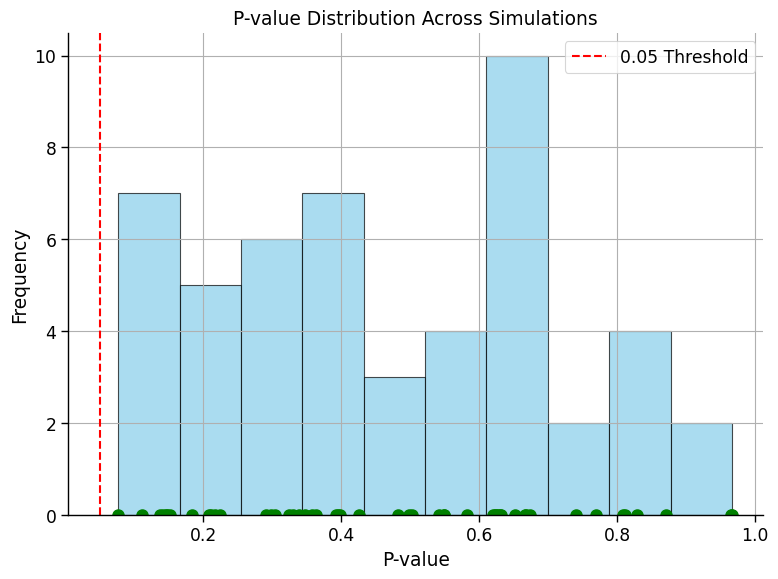

In [ ]:
# Call the run_simulation_ks_tests method
ks_results = latterbach.run_simulation_ks_tests(
    observed_data=observed,          # Pass the observed data instance
    column="Precipitation",     # Specify the column to compare
    quantile=0.95               # Specify the quantile for truncation
)

# Output the results
latterbach.plot_ks_results(ks_results)

## Running the Bucket Model
#### Preprocessing the data to match the format required by the Bucket Model


In [ ]:
processed_present_data = preprocess_for_bucket_model(present_data)
latterbach_preprocessed = preprocess_for_bucket_model(latterbach_out)


In [ ]:
processed_present_data

,P_mix,T_max,T_min
date,,,
1980-01-01,7.6,-5.6,-9.2
1980-01-02,4.8,-8.5,-11.1
1980-01-03,1.4,-9.6,-13.4
1980-01-04,6.9,-10.7,-13.4
1980-01-05,4.6,-7.0,-13.9
...,...,...,...
2009-12-27,0.1,-12.5,-17.8
2009-12-28,3.5,-10.5,-15.0
2009-12-29,1.1,-13.2,-18.3


In [ ]:
latterbach_preprocessed

,P_mix,T_max,T_min,Simulation
date,,,,
1980-01-01,0.000000,-3.862629,-10.154036,1
1980-01-02,0.000000,-1.382266,-7.578902,1
1980-01-03,0.000000,-2.406687,-8.094587,1
1980-01-04,0.000000,-3.055889,-10.305736,1
1980-01-05,9.820496,-5.220912,-11.212790,1
...,...,...,...,...
2009-12-27,0.000000,-5.001694,-13.664041,50
2009-12-28,0.000000,-6.475012,-15.756466,50
2009-12-29,0.000000,-2.456553,-12.647248,50


### Setting up the model for the catchment. Here I use the calibrated parameters from Assignment 2

In [ ]:
bucket_model = BucketModel(
    k=1.0, S_max=48.585, fr=0.102, rg=30.747, snow_threshold_temp=0.29
)  # Parameters from Assignment 2

bucket_model.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    basin_mean_elevation=1872,  # m.a.s.l
    hru_mean_elevation=1872,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.5,  # °N
)


### Running the model for the present data and visualising the results

In [ ]:
present_results = bucket_model.run(data=processed_present_data)

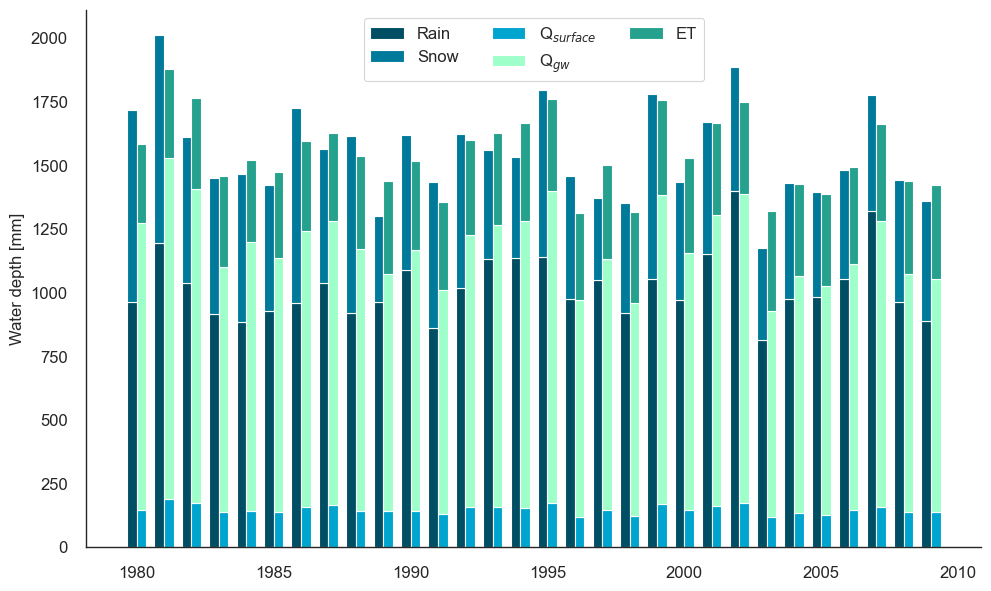

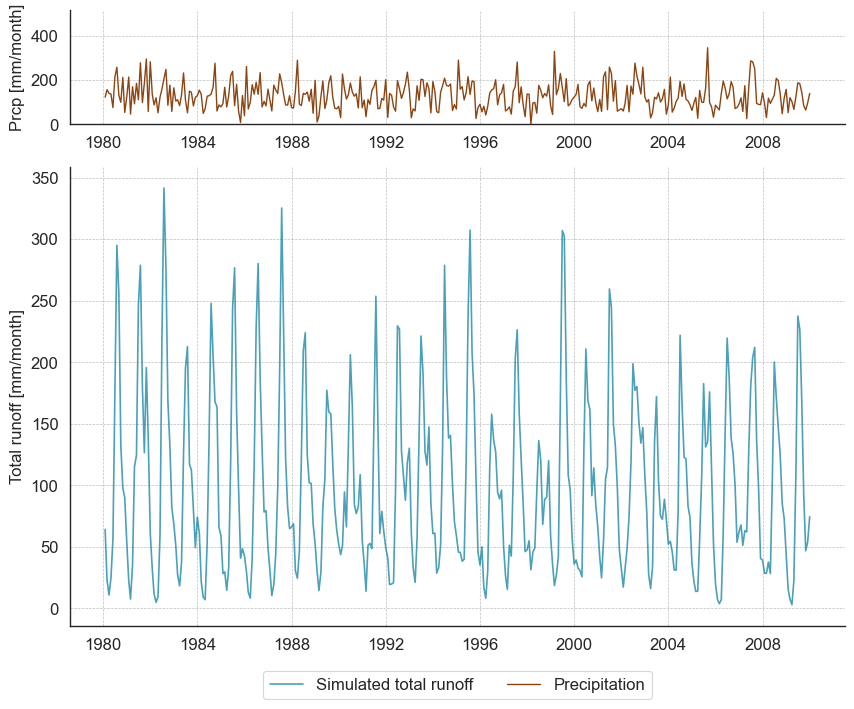

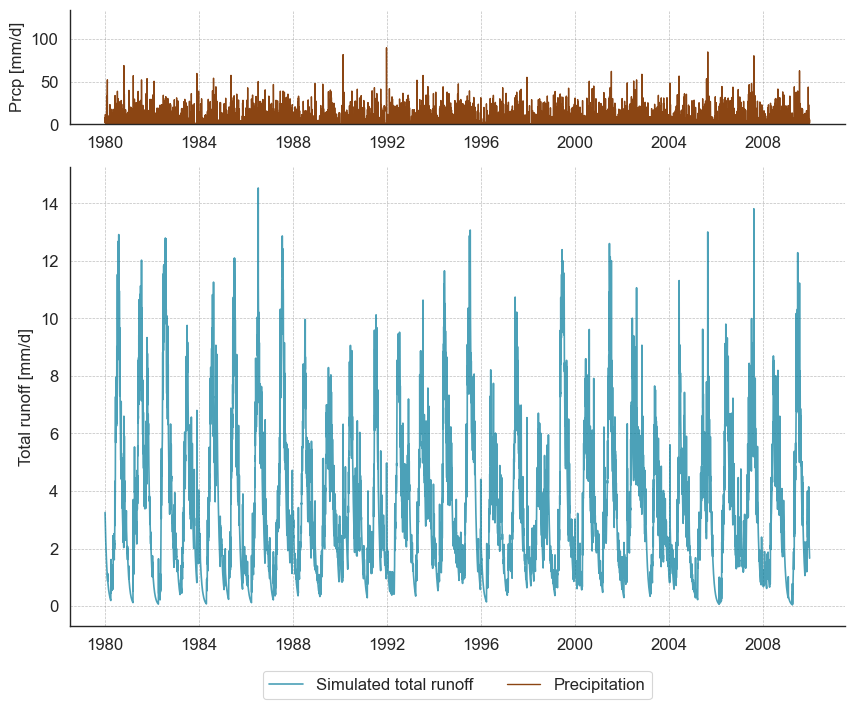

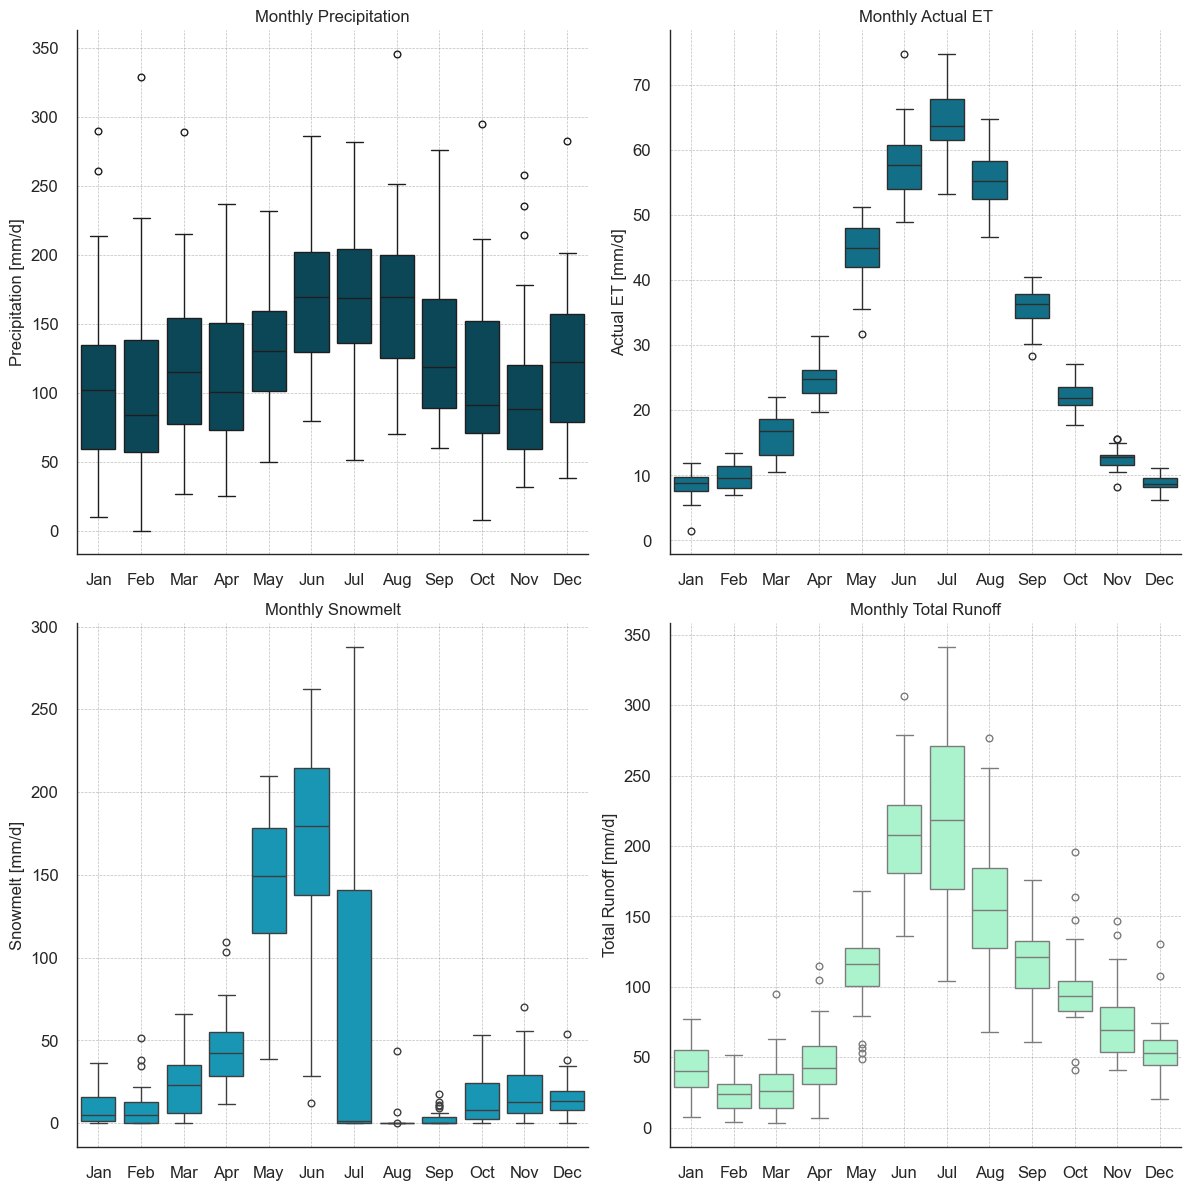

In [ ]:
plot_water_balance(results=present_results, start_year="1980", end_year="2010")

plot_timeseries(
    results=present_results,
    start_year="1980",
    end_year="2010",
    monthly=True,
    plot_precipitation=True,
)
plot_timeseries(
    results=present_results,
    start_year="1980",
    end_year="2010",
    monthly=False,
    plot_precipitation=True,
)
plot_monthly_boxplot(results=present_results)

### Run the model for each Simulation individually. Here _Simulation_ refers to the number of 30 years ensembles generated with WeaGETS.

In [ ]:
multiple_results = run_multiple_simulations(
    preprocessed_simulated_data=latterbach_preprocessed,
    bucket_model=bucket_model,
    n_simulations=50,
)

In [ ]:
multiple_results

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,Simulation
1980-01-01,0.041815,0.0,3.252350,0.000000,9.958185,96.747650,0.0,0.0,0.000000,0.000000,1
1980-01-02,0.050209,0.0,3.146572,0.000000,9.907977,93.601078,0.0,0.0,0.000000,0.000000,1
1980-01-03,0.047430,0.0,3.044234,0.000000,9.860547,90.556844,0.0,0.0,0.000000,0.000000,1
1980-01-04,0.042701,0.0,2.945225,0.000000,9.817846,87.611618,0.0,0.0,0.000000,0.000000,1
1980-01-05,0.038119,0.0,2.849436,9.820496,9.779727,84.762182,0.0,0.0,9.820496,9.820496,1
...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,0.158599,0.0,1.659735,73.531317,45.485562,49.372132,0.0,0.0,0.000000,0.000000,50
2009-12-28,0.138361,0.0,1.605754,73.531317,45.347201,47.766378,0.0,0.0,0.000000,0.000000,50
2009-12-29,0.180652,0.0,1.553530,73.531317,45.166548,46.212848,0.0,0.0,0.000000,0.000000,50
2009-12-30,0.163816,0.0,1.503003,73.531317,45.002733,44.709845,0.0,0.0,0.000000,0.000000,50


### Grouping the results by month and computing the 95% confidence interval

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,8.304438,2.790287,35.829826,4688.940870,1406.222966,1086.038785,12.457486,18.307951,91.898241,110.206192,38.620113
2,25.5,1994.5,9.610007,2.249228,22.342540,6419.718181,1249.510937,680.072057,11.714075,14.863574,85.054111,99.917685,24.591767
3,25.5,1994.5,15.897836,3.718090,21.559948,9315.374318,1378.283563,665.821999,21.729511,23.203257,88.418198,111.621455,25.278038
4,25.5,1994.5,25.208963,9.069429,34.834474,10515.402034,1389.537919,1097.413078,49.880257,47.852209,70.156247,118.008456,43.903903
5,25.5,1994.5,43.007854,23.160852,84.554026,9553.399432,1491.794431,2678.902789,132.817437,98.101370,28.825999,126.927369,107.714878
6,25.5,1994.5,58.686140,35.130770,175.934678,4603.849719,1441.360828,5488.915731,183.847170,164.097647,6.489340,170.586987,211.065448
7,25.5,1994.5,65.310572,23.383936,198.390147,695.008159,1420.980997,6059.484837,68.275083,175.602381,0.814500,176.416881,221.774083
8,25.5,1994.5,54.844220,14.877554,141.206008,10.317309,1389.840588,4293.208126,2.061310,161.780705,0.316040,162.096746,156.083562
9,25.5,1994.5,37.047323,12.438995,107.623361,5.906478,1371.566863,3284.459712,1.872734,130.285570,2.305108,132.590678,120.062356


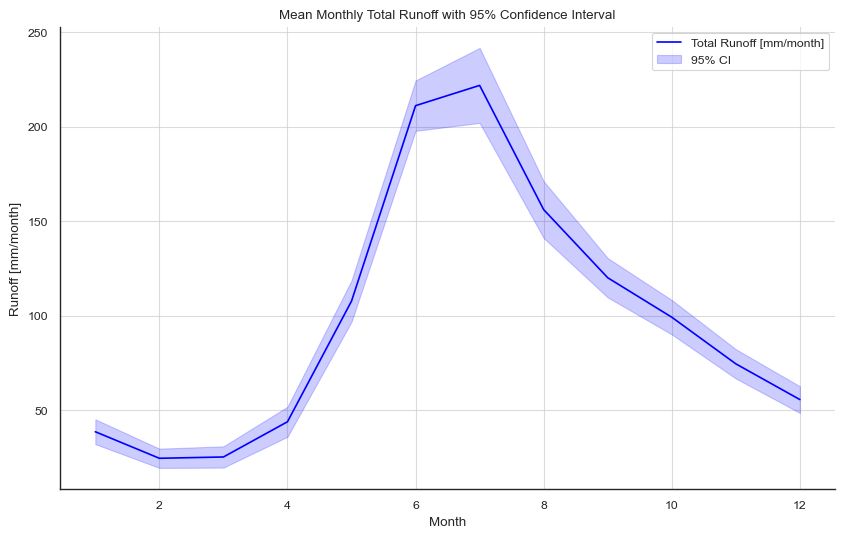

In [ ]:
monthly_mean, ci = group_by_month_with_ci(multiple_results)

plot_monthly_runoff_with_ci(monthly_mean, ci)

monthly_mean

# TODO: remove simulation column

## (Week 2) Assessing the changes to streamflow in a future climate
### Generate a future climate ensemble consisting of n multiple realizations (simulations) for 5 climate trajectories (climate models) and 2 different greenhouse gas (GHG) emission scenarios applying the delta-change approach.

In [ ]:
generate_future_climate(
    data=latterbach_out,
    name="exp_first",
    output_folder="C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates",
)

Generating future climate data. Be patient...
Future climate data for CLMCOM-CCLM4-ECEARTH RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-ECEARTH_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-ECEARTH RCP8.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-ECEARTH_RCP8.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-HADGEM_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP8.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-HADGEM_RCP8.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_DMI-HIRHAM-ECEARTH_RCP4.5.csv
Future 

### Simulate future streamflow using the future climate ensemble and the Bucket

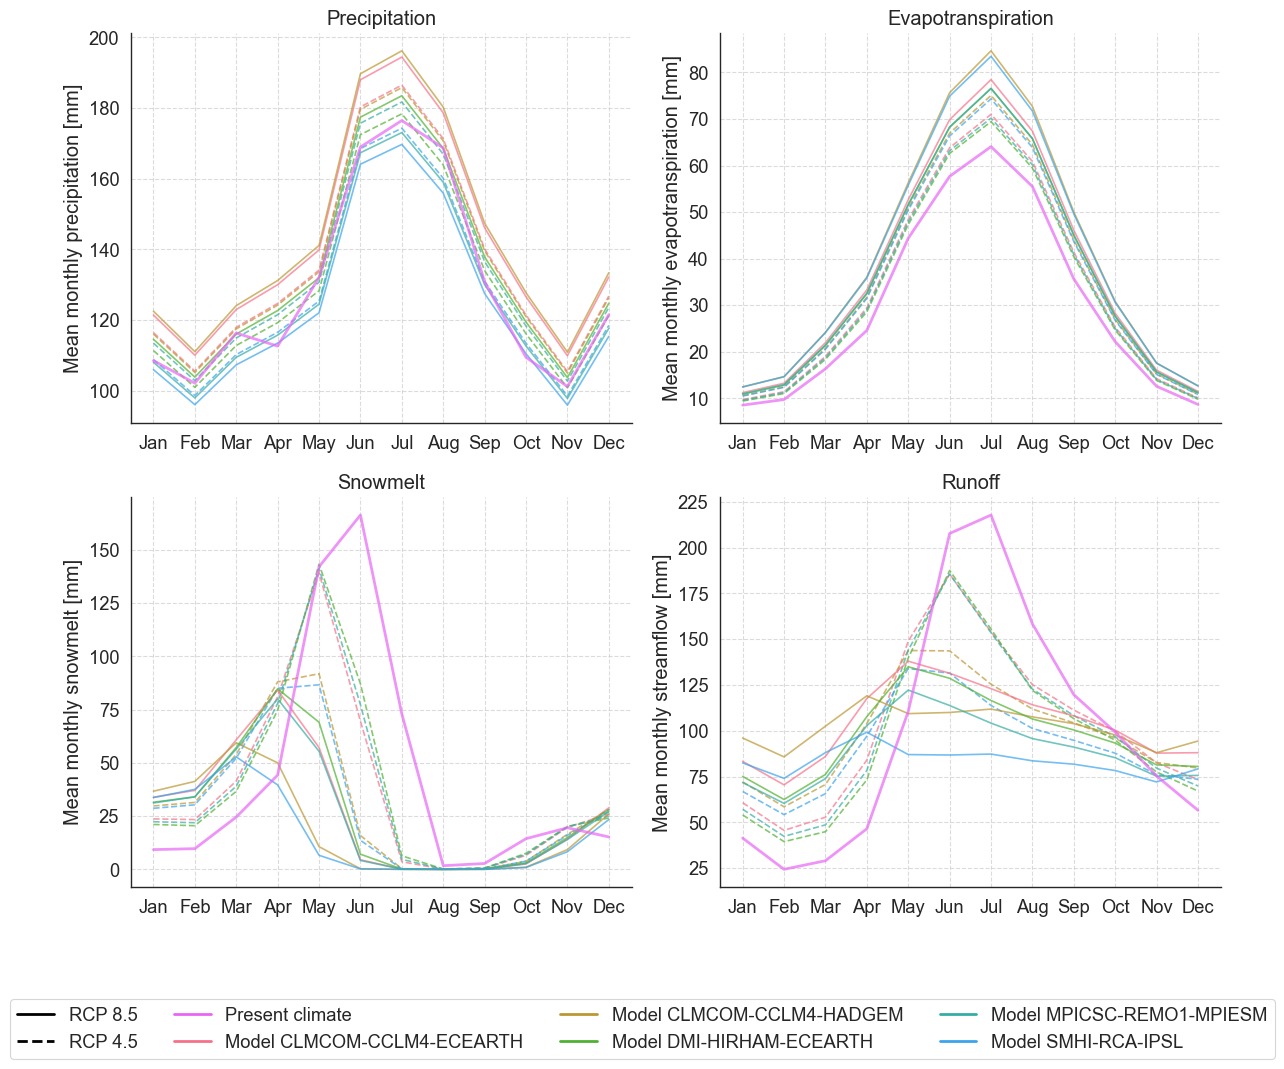

In [ ]:
future_data_folder = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates"
results = run_model_for_future_climate(
    future_data_folder=future_data_folder,
    bucket_model=bucket_model,
)

# Prepare present data for plotting
present_monthly_mean, _ = group_by_month_with_ci(present_results)
present_monthly_mean['total_runoff'] = present_monthly_mean['Q_s'] + present_monthly_mean['Q_gw']

plot_climate_scenarios(
    results,
    present_results=present_monthly_mean,
) # Again, you can add the output_destination parameter to save the plot

### Simulate future streamflow using the future climate ensemble and the Bucket Model

In [ ]:
folder_path1 = future_data_folder # Path to the folder containing the future climate scenarios
combined_df = simulate_and_aggregate_streamflows(folder_path1, bucket_model, 50)

In [ ]:
combined_df

,Simulation,Streamflow,Climate_Model,Scenario
0,1,1191.342398,CLMCOM_CCLM4_ECEARTH,RCP4.5
1,2,1228.114880,CLMCOM_CCLM4_ECEARTH,RCP4.5
2,3,1201.191708,CLMCOM_CCLM4_ECEARTH,RCP4.5
3,4,1259.004499,CLMCOM_CCLM4_ECEARTH,RCP4.5
4,5,1194.014775,CLMCOM_CCLM4_ECEARTH,RCP4.5
...,...,...,...,...
495,46,1019.258126,SMHI_RCA_IPSL,RCP8.5
496,47,1022.031296,SMHI_RCA_IPSL,RCP8.5
497,48,1010.233629,SMHI_RCA_IPSL,RCP8.5
498,49,989.810641,SMHI_RCA_IPSL,RCP8.5


### Partition the hydrological (streamflow) uncertainties predicted in a future climate into their climatic sources – emission uncertainty, climate model uncertainty, and stochastic uncertainty

In [ ]:
uncertainty = UncertaintyAnalysis(combined_df)

tu = uncertainty.calculate_tu('Streamflow')
eu, eu_partition = uncertainty.calculate_eu('Streamflow', tu)
cmu, cmu_partition = uncertainty.calculate_cmu('Streamflow', tu)
su, su_partition = uncertainty.calculate_su('Streamflow', tu)

print(f"Total Uncertainty: {tu}")
print(f"Emission Scenario Uncertainty: {eu} (Partition: {eu_partition})")
print(f"Climate Model Uncertainty: {cmu} (Partition: {cmu_partition})")
print(f"Stochastic Uncertainty: {su} (Partition: {su_partition})")

Total Uncertainty: 271.85
Emission Scenario Uncertainty: 19.75 (Partition: 0.07)
Climate Model Uncertainty: 187.85 (Partition: 0.69)
Stochastic Uncertainty: 99.9 (Partition: 0.37)
